 Based on 0304534

In [2]:
from kSZ_forecast_general_func import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
Grid = 512
MAS  = "NGP"
Snapshot = 2448

snap_info=Snap_Info()

In [3]:
#data =np.loadtxt("/home/chenzy/code/kSZ/1COMPRESS/zlist.txt" ,skiprows=1)
#step =data[:,0]
#redshift = data[:,2]
#step[::-1], redshift[::-1]

(100, 10000)

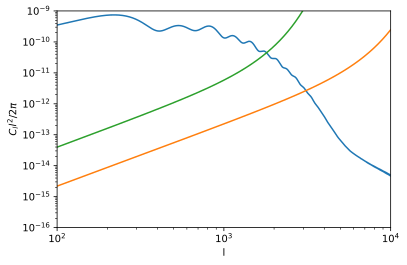

In [9]:
l,cl_cmb=cmbcl(lmax=15000)
l,cl_noise1=cmbnoise(Delta_T=cmbsur[0][0],sigma=cmbsur[0][1],lmax=15000)
l,cl_noise2=cmbnoise(Delta_T=cmbsur[1][0],sigma=cmbsur[1][1],lmax=15000)
plt.plot(l,cl_cmb*l**2/2/np.pi)
plt.plot(l,cl_noise1*l**2/2/np.pi)
plt.plot(l,cl_noise2*l**2/2/np.pi)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("l")
plt.ylabel(r"$C_ll^2/2\pi$")
plt.ylim(10**-16, 10**-9)
plt.xlim(100, 10**4)

# Generat power spectrum of B-mode momentum

In [ ]:
Grid = 512
for Snapshot in [5000, 3356, 2448, 1631, 1216, 958, 799]:
    Mom_dir = "/home/chenzy/data/mommap/mom"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
    momp=snap_info.get_vel_norm(Snapshot)*np.fromfile(Mom_dir, dtype=np.float32, count=3*Grid**3, sep="").reshape(Grid,Grid,Grid,3)
    momp_E, momp_B = fa.BEdec(momp, Grid)
    ps_momp_B, k = fa.CalPSvector(momp_B, Grid, mapscale=(Boxlen/Grid**2)**3, kscale=2*np.pi/Boxlen)
    redshift = snap_info.get_redshift(Snapshot)
    
    file_name = "data/Power_Spectrum_momp_B_"+str(Snapshot)+"_"+str(Grid)+".npz"
    
    np.savez(file_name, k = k, Delta2_B = k**3/(2*np.pi**2)*ps_momp_B, redshift =redshift)

# forecast kSZ Cl

In [3]:
#cal_cl_kSZ(z_min=0, z_max=5, n_zbin=501, lgl_min=2, lgl_max=4, n_lglbin=80, grid=1024)

1.5369962445898167

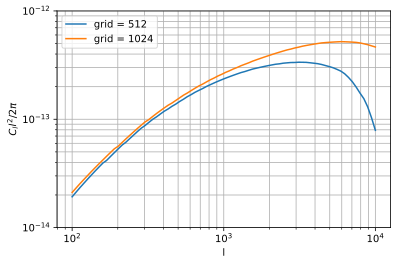

In [4]:
fig, ax = plt.subplots()
for grid in [512, 1024]:
    l, Cl_kSZ = cal_cl_kSZ(grid = grid)
    ax.plot(l, Cl_kSZ*l**2/2/np.pi, label = "grid = "+str(grid))
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(which ="both")
ax.set_ylim(10**-14, 10**-12)
ax.set_xlabel("l")
ax.set_ylabel(r"$C_ll^2/2\pi$")
8*10**-13/np.max(Cl_kSZ*l**2/2/np.pi)

Text(0, 0.5, 'ratio')

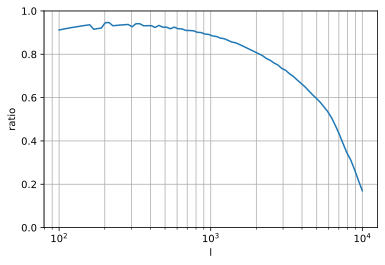

In [6]:
fig, ax = plt.subplots()

l, Cl_kSZ_512 = cal_cl_kSZ(grid = 512)
l, Cl_kSZ_1024 = cal_cl_kSZ(grid = 1024)
ax.plot(l, Cl_kSZ_512/Cl_kSZ_1024)

ax.set_xscale("log")
ax.grid(which ="both")
ax.set_ylim(0,1)
ax.set_xlabel("l")
ax.set_ylabel(r"ratio")

Text(0, 0.5, 'k h/Mpc')

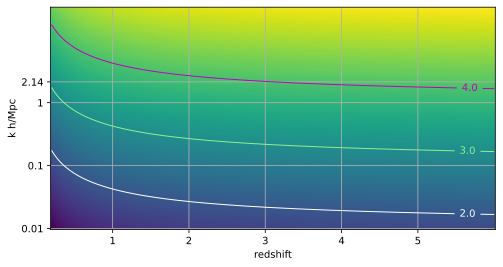

In [8]:
k = 10**np.linspace(-2,1.5,100)
z_array= np.linspace(0.2,6, len(k)*2)
dc = cosmo.comoving_distance(z_array).value*h

l = dc.reshape(1,-1)*k.reshape(-1,1)

dlgk = np.mean(np.log10(k[1:])-np.log10(k[:-1]))

fig, ax = plt.subplots(figsize = (8, 4.4))
ax.imshow(np.log10(l), origin = "lower")
ax.set_xticks((np.array([1,2,3,4,5])-0.2)/(z_array[1]-z_array[0]))
ax.set_xticklabels(["1", "2", "3", "4", "5"])
ax.set_yticks((np.log10(np.array([0.01, 0.1, 1, 2.14]))-np.log10(k[0]))/dlgk)
ax.set_yticklabels(["0.01", "0.1", "1", "2.14"])

level = [2, 3, 4]
CS2=ax.contour(np.log10(l),level,colors=["w","lightgreen","m",],linewidths=1)
fmt = ticker.ScalarFormatter(["2","3","4"])
fmt.create_dummy_axis()
ax.clabel(CS2,fmt='%.1f')
ax.grid()
ax.set_xlabel("redshift")
ax.set_ylabel("k h/Mpc")

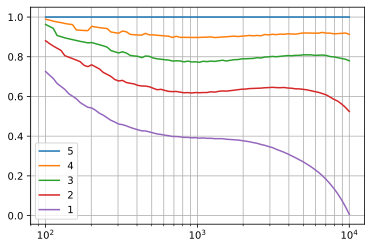

In [7]:
fig, ax = plt.subplots()
l, Cl_kSZ0 = cal_cl_kSZ(z_max = 5, grid=1024)
for z_max in [5, 4, 3, 2, 1]:
    l, Cl_kSZ = cal_cl_kSZ(z_max = z_max, grid=1024)
    ax.plot(l, Cl_kSZ/Cl_kSZ0, label = str(z_max))
ax.set_xscale("log")
#ax.set_yscale("log")
ax.grid(which ="both")
#ax.set_ylim(10**-14, 10**-12)
ax.legend()

# the very ideal case of S/N prediction

In [6]:
def very_ideal_SN_prediction(zmin=0, zmax=5, f_sky=1,  CMB_survey="Planck", grid = 1024):
    if CMB_survey=="Planck":
        ss = 1
    elif CMB_survey=="ACT":
        ss=0
    else:
        print("CMB survey error")
        
    lll,cl_cmb=cmbcl(lmax=15000)
    lll,cl_noise=cmbnoise(Delta_T=cmbsur[ss][0],sigma=cmbsur[ss][1],lmax=15000)

    f_cmb = interpolate.interp1d(lll, cl_cmb)
    f_noise = interpolate.interp1d(lll, cl_noise)

    l, Cl_kSZ = cal_cl_kSZ(z_min=zmin, z_max=zmax, grid=grid, n_lglbin=20, lgl_max = np.log10(6000))
    dlnl = np.log(l[1])-np.log(l[0])
    
    NS = np.sqrt((f_cmb(l)+f_noise(l))/Cl_kSZ/(2*l**2*dlnl*f_sky))
    SN = np.sqrt(np.sum(1/NS**2))
    
    return l, NS, SN

Text(0.5, 1.0, 'very ideal case, f_sky = 0.03, ACT,  z:1.65~2.45')

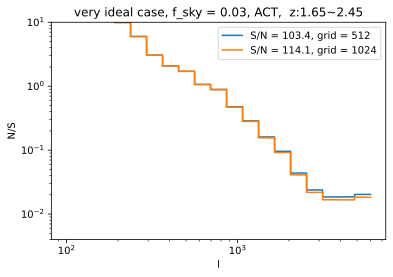

In [7]:
zmin = 1.65
zmax = 2.45
f_sky = 1400/(4*np.pi*(180/np.pi)**2)
CMB_survey="ACT"
fig, ax = plt.subplots()
for grid in [512, 1024]:
    l, NS, SN = very_ideal_SN_prediction(zmin=zmin, zmax=zmax, f_sky=f_sky, CMB_survey=CMB_survey, grid = grid, )
    ax.step(l, NS, label = "S/N = "+str(np.round(SN, 2))+", grid = "+str(grid))
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.004, 10)
ax.set_xlabel("l")
ax.set_ylabel("N/S")
ax.legend()
ax.set_title("very ideal case, f_sky = "+str(np.round(f_sky,2))+", "+CMB_survey+",  z:"+str(zmin)+"~"+str(zmax))

In [3]:
ss = 1
lll,cl_cmb=cmbcl(lmax=15000)
lll,cl_noise=cmbnoise(Delta_T=cmbsur[ss][0],sigma=cmbsur[ss][1],lmax=15000)

f_cmb = interpolate.interp1d(lll, cl_cmb)
f_noise = interpolate.interp1d(lll, cl_noise)

l, Cl_kSZ = cal_cl_kSZ(grid=1024)

In [9]:
dlnl = np.log(l[1])-np.log(l[0])

141.99006630950643

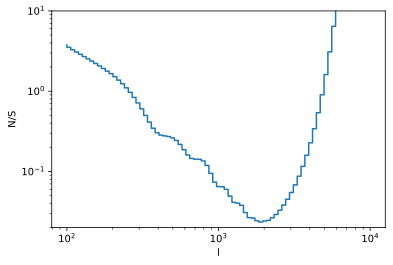

In [18]:
NS = np.sqrt((f_cmb(l)+f_noise(l))/Cl_kSZ/(2*l**2*dlnl))
plt.step(l, NS)
plt.xscale("log")
plt.yscale("log")
plt.ylim(0.02, 10)
plt.xlabel("l")
plt.ylabel("N/S")
np.sqrt(np.sum(1/NS**2))